In [14]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

import albumentations as A

from albumentations.pytorch import ToTensor, ToTensorV2 
from albumentations import (HorizontalFlip,
                            VerticalFlip,
                            Normalize,
                            Compose)

from segmentation_models_pytorch import Unet

In [15]:
# cuda device allocation
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

In [16]:
# Load model
pretrained_model_path = './seg_pretrained_100_epoch.pth'
model = Unet('efficientnet-b2', encoder_weights="imagenet", classes=3, activation=None)
model = model.eval().cuda()
model.load_state_dict(torch.load(pretrained_model_path))

# Transform to use seg model
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

transforms = A.Compose(
        [
            A.Normalize(mean=mean, std=std, p=1),
            A.pytorch.ToTensorV2(),
        ]
    )

In [4]:
path = '/data/kdu/covid_eccv'
import time
import natsort
# files_train_pos = natsort.natsorted(files_train_pos)
#test
#set1
train_pos = os.path.join(path,'test/set1')
folders_train_pos = os.listdir(train_pos)
#folders_train_pos.sort()
folders_train_pos = natsort.natsorted(folders_train_pos)
for fol in folders_train_pos:
    files_train_pos = glob.glob(os.path.join(train_pos,fol,'*.jpg'))
    #files_train_pos.sort()
    files_train_pos = natsort.natsorted(files_train_pos)
    # 볼륨 내에서 slice 들끼리 영상 사이즈가 다른 경우들이 있음. 그래서 모든 슬라이스 불러서 사이즈 체크 해야함.
    img_list = []
    img_path_list = []
    if len(files_train_pos) < 32:
        continue
        
    for img_path in files_train_pos:
        #img load and normalization
        img_ori = cv2.imread(img_path)
        h,w,c = img_ori.shape
        if h != 512 and h != 768:
            break
        elif h == 768:
            img_ori = cv2.resize(img_ori, (512,512))
            img_list.append(img_ori)
            img_path_list.append(img_path)
        else:     
            img_list.append(img_ori)
            img_path_list.append(img_path)
            
    if len(img_list) == len(files_train_pos):
        st = 0    
        for idx, img_ori in enumerate(img_list):
            img = transforms(image=img_ori)['image'][None,:,:,:]

            #model inference
            out_lung  = model(img.cuda())
            out_lung = out_lung.cpu().detach()
            out_lung = torch.sigmoid(out_lung)

            out_lung_np = out_lung.squeeze(dim=0).permute(1,2,0).numpy()
            out_lung_np[out_lung_np>=0.5] = 1
            out_lung_np[out_lung_np<0.5] = 0
            out_lung_np = out_lung_np[:,:,0:1]

            # pre-processing
            lung_seg = (out_lung_np==1).sum()
            h,w,c = out_lung_np.shape

            percentage = lung_seg / (h*w)

            if percentage < 0.05:
                st += 1
                continue
            else :   
                break
                #cv2.imwrite(save_path, (img_ori*out_lung_np).astype('uint8'))

        et = 1    
        img_list.reverse()
        img_path_list.reverse()
        for idx, img_ori in enumerate(img_list):
            img = transforms(image=img_ori)['image'][None,:,:,:]

            #model inference
            out_lung  = model(img.cuda())
            out_lung = out_lung.cpu().detach()
            out_lung = torch.sigmoid(out_lung)

            out_lung_np = out_lung.squeeze(dim=0).permute(1,2,0).numpy()
            out_lung_np[out_lung_np>=0.5] = 1
            out_lung_np[out_lung_np<0.5] = 0
            out_lung_np = out_lung_np[:,:,0:1]

            # pre-processing
            lung_seg = (out_lung_np==1).sum()
            h,w,c = out_lung_np.shape

            percentage = lung_seg / (h*w)
            if percentage < 0.05:
                et += 1
                continue
            else :     
                break

        # select img_list by searched range of lung slices within ct volume        
        img_list.reverse()
        img_path_list.reverse()   
        img_list = img_list[st:-et]
        img_path_list = img_path_list[st:-et]            
        
        for idx, img_ori in enumerate(img_list):
            img = transforms(image=img_ori)['image'][None,:,:,:]

            #model inference
            out_lung  = model(img.cuda())
            out_lung = out_lung.cpu().detach()
            out_lung = torch.sigmoid(out_lung)

            out_lung_np = out_lung.squeeze(dim=0).permute(1,2,0).numpy()
            out_lung_np[out_lung_np>=0.5] = 1
            out_lung_np[out_lung_np<0.5] = 0
            out_lung_np = out_lung_np[:,:,0:1]

            # save directory check
            save_path = img_path_list[idx].replace('covid_eccv','covid_eccv_pc5_segment')
            #save_path = img_path_list[idx].replace('covid_eccv','covid_eccv_pc5_original')
            save_folder, _ = os.path.split(save_path)
            if not os.path.exists(save_folder):
                os.makedirs(save_folder)

            # pre-processing
            lung_seg = (out_lung_np==1).sum()
            h,w,c = out_lung_np.shape

            percentage = lung_seg / (h*w)

            if percentage < 0.05:
                continue
            else :     
                cv2.imwrite(save_path, (img_ori*out_lung_np).astype('uint8')) #covid_eccv_pc5_segment
                #cv2.imwrite(save_path, (img_ori).astype('uint8')) #covid_eccv_pc5_original


AttributeError: 'NoneType' object has no attribute 'shape'

In [5]:
path = '/data/kdu/covid_eccv'
import time
import natsort
# files_train_pos = natsort.natsorted(files_train_pos)
#train
#set2
train_pos = os.path.join(path,'test/set2')
folders_train_pos = os.listdir(train_pos)
#folders_train_pos.sort()
folders_train_pos = natsort.natsorted(folders_train_pos)
for fol in folders_train_pos:
    files_train_pos = glob.glob(os.path.join(train_pos,fol,'*.jpg'))
    #files_train_pos.sort()
    files_train_pos = natsort.natsorted(files_train_pos)
    # 볼륨 내에서 slice 들끼리 영상 사이즈가 다른 경우들이 있음. 그래서 모든 슬라이스 불러서 사이즈 체크 해야함.
    img_list = []
    img_path_list = []
    if len(files_train_pos) < 32:
        continue
    
    for img_path in files_train_pos:
        #img load and normalization
        img_ori = cv2.imread(img_path)
        h,w,c = img_ori.shape
        if h != 512 and h != 768:
            break
        elif h == 768:
            img_ori = cv2.resize(img_ori, (512,512))
            img_list.append(img_ori)
            img_path_list.append(img_path)
        else:     
            img_list.append(img_ori)
            img_path_list.append(img_path)
            
    if len(img_list) == len(files_train_pos):
        st = 0    
        for idx, img_ori in enumerate(img_list):
            img = transforms(image=img_ori)['image'][None,:,:,:]

            #model inference
            out_lung  = model(img.cuda())
            out_lung = out_lung.cpu().detach()
            out_lung = torch.sigmoid(out_lung)

            out_lung_np = out_lung.squeeze(dim=0).permute(1,2,0).numpy()
            out_lung_np[out_lung_np>=0.5] = 1
            out_lung_np[out_lung_np<0.5] = 0
            out_lung_np = out_lung_np[:,:,0:1]

            # pre-processing
            lung_seg = (out_lung_np==1).sum()
            h,w,c = out_lung_np.shape

            percentage = lung_seg / (h*w)

            if percentage < 0.05:
                st += 1
                continue
            else :   
                break
                #cv2.imwrite(save_path, (img_ori*out_lung_np).astype('uint8'))

        et = 1    
        img_list.reverse()
        img_path_list.reverse()
        for idx, img_ori in enumerate(img_list):
            img = transforms(image=img_ori)['image'][None,:,:,:]

            #model inference
            out_lung  = model(img.cuda())
            out_lung = out_lung.cpu().detach()
            out_lung = torch.sigmoid(out_lung)

            out_lung_np = out_lung.squeeze(dim=0).permute(1,2,0).numpy()
            out_lung_np[out_lung_np>=0.5] = 1
            out_lung_np[out_lung_np<0.5] = 0
            out_lung_np = out_lung_np[:,:,0:1]

            # pre-processing
            lung_seg = (out_lung_np==1).sum()
            h,w,c = out_lung_np.shape

            percentage = lung_seg / (h*w)
            if percentage < 0.05:
                et += 1
                continue
            else :     
                break

        # select img_list by searched range of lung slices within ct volume        
        img_list.reverse()
        img_path_list.reverse()   
        img_list = img_list[st:-et]
        img_path_list = img_path_list[st:-et]            
        
        for idx, img_ori in enumerate(img_list):
            img = transforms(image=img_ori)['image'][None,:,:,:]

            #model inference
            out_lung  = model(img.cuda())
            out_lung = out_lung.cpu().detach()
            out_lung = torch.sigmoid(out_lung)

            out_lung_np = out_lung.squeeze(dim=0).permute(1,2,0).numpy()
            out_lung_np[out_lung_np>=0.5] = 1
            out_lung_np[out_lung_np<0.5] = 0
            out_lung_np = out_lung_np[:,:,0:1]

            # save directory check
            save_path = img_path_list[idx].replace('covid_eccv','covid_eccv_pc5_segment')
            #save_path = img_path_list[idx].replace('covid_eccv','covid_eccv_pc5_original')
            save_folder, _ = os.path.split(save_path)
            if not os.path.exists(save_folder):
                os.makedirs(save_folder)

            # pre-processing
            lung_seg = (out_lung_np==1).sum()
            h,w,c = out_lung_np.shape

            percentage = lung_seg / (h*w)

            if percentage < 0.05:
                continue
            else :     
                cv2.imwrite(save_path, (img_ori*out_lung_np).astype('uint8')) #covid_eccv_pc5_segment
                #cv2.imwrite(save_path, (img_ori).astype('uint8')) #covid_eccv_pc5_original


In [10]:
path = '/data/kdu/covid_eccv'
import time
import natsort
# files_train_pos = natsort.natsorted(files_train_pos)
#test
#set3
train_pos = os.path.join(path,'test/set3')
folders_train_pos = os.listdir(train_pos)
#folders_train_pos.sort()
folders_train_pos = natsort.natsorted(folders_train_pos)
for fol in folders_train_pos:
    files_train_pos = glob.glob(os.path.join(train_pos,fol,'*.jpg'))
    #files_train_pos.sort()
    files_train_pos = natsort.natsorted(files_train_pos)
    # 볼륨 내에서 slice 들끼리 영상 사이즈가 다른 경우들이 있음. 그래서 모든 슬라이스 불러서 사이즈 체크 해야함.
    img_list = []
    img_path_list = []
    if len(files_train_pos) < 32:
        continue
        
    for img_path in files_train_pos:
        #img load and normalization
        img_ori = cv2.imread(img_path)
        h,w,c = img_ori.shape
        if h != 512 and h != 768:
            break
        elif h == 768:
            img_ori = cv2.resize(img_ori, (512,512))
            img_list.append(img_ori)
            img_path_list.append(img_path)
        else:     
            img_list.append(img_ori)
            img_path_list.append(img_path)
            
    if len(img_list) == len(files_train_pos):
        st = 0    
        for idx, img_ori in enumerate(img_list):
            img = transforms(image=img_ori)['image'][None,:,:,:]

            #model inference
            out_lung  = model(img.cuda())
            out_lung = out_lung.cpu().detach()
            out_lung = torch.sigmoid(out_lung)

            out_lung_np = out_lung.squeeze(dim=0).permute(1,2,0).numpy()
            out_lung_np[out_lung_np>=0.5] = 1
            out_lung_np[out_lung_np<0.5] = 0
            out_lung_np = out_lung_np[:,:,0:1]

            # pre-processing
            lung_seg = (out_lung_np==1).sum()
            h,w,c = out_lung_np.shape

            percentage = lung_seg / (h*w)

            if percentage < 0.05:
                st += 1
                continue
            else :   
                break
                #cv2.imwrite(save_path, (img_ori*out_lung_np).astype('uint8'))

        et = 1    
        img_list.reverse()
        img_path_list.reverse()
        for idx, img_ori in enumerate(img_list):
            img = transforms(image=img_ori)['image'][None,:,:,:]

            #model inference
            out_lung  = model(img.cuda())
            out_lung = out_lung.cpu().detach()
            out_lung = torch.sigmoid(out_lung)

            out_lung_np = out_lung.squeeze(dim=0).permute(1,2,0).numpy()
            out_lung_np[out_lung_np>=0.5] = 1
            out_lung_np[out_lung_np<0.5] = 0
            out_lung_np = out_lung_np[:,:,0:1]

            # pre-processing
            lung_seg = (out_lung_np==1).sum()
            h,w,c = out_lung_np.shape

            percentage = lung_seg / (h*w)
            if percentage < 0.05:
                et += 1
                continue
            else :     
                break

        # select img_list by searched range of lung slices within ct volume        
        img_list.reverse()
        img_path_list.reverse()   
        img_list = img_list[st:-et]
        img_path_list = img_path_list[st:-et]            
        
        for idx, img_ori in enumerate(img_list):
            img = transforms(image=img_ori)['image'][None,:,:,:]

            #model inference
            out_lung  = model(img.cuda())
            out_lung = out_lung.cpu().detach()
            out_lung = torch.sigmoid(out_lung)

            out_lung_np = out_lung.squeeze(dim=0).permute(1,2,0).numpy()
            out_lung_np[out_lung_np>=0.5] = 1
            out_lung_np[out_lung_np<0.5] = 0
            out_lung_np = out_lung_np[:,:,0:1]

            # save directory check
            save_path = img_path_list[idx].replace('covid_eccv','covid_eccv_pc5_segment')
            #save_path = img_path_list[idx].replace('covid_eccv','covid_eccv_pc5_original')
            save_folder, _ = os.path.split(save_path)
            if not os.path.exists(save_folder):
                os.makedirs(save_folder)

            # pre-processing
            lung_seg = (out_lung_np==1).sum()
            h,w,c = out_lung_np.shape

            percentage = lung_seg / (h*w)

            if percentage < 0.05:
                continue
            else :     
                cv2.imwrite(save_path, (img_ori*out_lung_np).astype('uint8')) #covid_eccv_pc5_segment
                #cv2.imwrite(save_path, (img_ori).astype('uint8')) #covid_eccv_pc5_original


In [8]:
path = '/data/kdu/covid_eccv'
import time
import natsort
# files_train_pos = natsort.natsorted(files_train_pos)
#test
#set4
train_pos = os.path.join(path,'test/set4')
folders_train_pos = os.listdir(train_pos)
#folders_train_pos.sort()
folders_train_pos = natsort.natsorted(folders_train_pos)
for fol in folders_train_pos:
    files_train_pos = glob.glob(os.path.join(train_pos,fol,'*.jpg'))
    #files_train_pos.sort()
    files_train_pos = natsort.natsorted(files_train_pos)
    # 볼륨 내에서 slice 들끼리 영상 사이즈가 다른 경우들이 있음. 그래서 모든 슬라이스 불러서 사이즈 체크 해야함.
    img_list = []
    img_path_list = []
    if len(files_train_pos) < 32:
        continue
        
    for img_path in files_train_pos:
        #img load and normalization
        img_ori = cv2.imread(img_path)
        h,w,c = img_ori.shape
        if h != 512 and h != 768:
            break
        elif h == 768:
            img_ori = cv2.resize(img_ori, (512,512))
            img_list.append(img_ori)
            img_path_list.append(img_path)
        else:     
            img_list.append(img_ori)
            img_path_list.append(img_path)
            
    if len(img_list) == len(files_train_pos):
        st = 0    
        for idx, img_ori in enumerate(img_list):
            img = transforms(image=img_ori)['image'][None,:,:,:]

            #model inference
            out_lung  = model(img.cuda())
            out_lung = out_lung.cpu().detach()
            out_lung = torch.sigmoid(out_lung)

            out_lung_np = out_lung.squeeze(dim=0).permute(1,2,0).numpy()
            out_lung_np[out_lung_np>=0.5] = 1
            out_lung_np[out_lung_np<0.5] = 0
            out_lung_np = out_lung_np[:,:,0:1]

            # pre-processing
            lung_seg = (out_lung_np==1).sum()
            h,w,c = out_lung_np.shape

            percentage = lung_seg / (h*w)

            if percentage < 0.05:
                st += 1
                continue
            else :   
                break
                #cv2.imwrite(save_path, (img_ori*out_lung_np).astype('uint8'))

        et = 1    
        img_list.reverse()
        img_path_list.reverse()
        for idx, img_ori in enumerate(img_list):
            img = transforms(image=img_ori)['image'][None,:,:,:]

            #model inference
            out_lung  = model(img.cuda())
            out_lung = out_lung.cpu().detach()
            out_lung = torch.sigmoid(out_lung)

            out_lung_np = out_lung.squeeze(dim=0).permute(1,2,0).numpy()
            out_lung_np[out_lung_np>=0.5] = 1
            out_lung_np[out_lung_np<0.5] = 0
            out_lung_np = out_lung_np[:,:,0:1]

            # pre-processing
            lung_seg = (out_lung_np==1).sum()
            h,w,c = out_lung_np.shape

            percentage = lung_seg / (h*w)
            if percentage < 0.05:
                et += 1
                continue
            else :     
                break

        # select img_list by searched range of lung slices within ct volume        
        img_list.reverse()
        img_path_list.reverse()   
        img_list = img_list[st:-et]
        img_path_list = img_path_list[st:-et]            
        
        for idx, img_ori in enumerate(img_list):
            img = transforms(image=img_ori)['image'][None,:,:,:]

            #model inference
            out_lung  = model(img.cuda())
            out_lung = out_lung.cpu().detach()
            out_lung = torch.sigmoid(out_lung)

            out_lung_np = out_lung.squeeze(dim=0).permute(1,2,0).numpy()
            out_lung_np[out_lung_np>=0.5] = 1
            out_lung_np[out_lung_np<0.5] = 0
            out_lung_np = out_lung_np[:,:,0:1]

            # save directory check
            save_path = img_path_list[idx].replace('covid_eccv','covid_eccv_pc5_segment')
            #save_path = img_path_list[idx].replace('covid_eccv','covid_eccv_pc5_original')
            save_folder, _ = os.path.split(save_path)
            if not os.path.exists(save_folder):
                os.makedirs(save_folder)

            # pre-processing
            lung_seg = (out_lung_np==1).sum()
            h,w,c = out_lung_np.shape

            percentage = lung_seg / (h*w)

            if percentage < 0.05:
                continue
            else :     
                cv2.imwrite(save_path, (img_ori*out_lung_np).astype('uint8')) #covid_eccv_pc5_segment
                #cv2.imwrite(save_path, (img_ori).astype('uint8')) #covid_eccv_pc5_original


In [11]:
path = '/data/kdu/covid_eccv'
import time
import natsort
# files_train_pos = natsort.natsorted(files_train_pos)
#test
#set5 
train_pos = os.path.join(path,'test/set5')
folders_train_pos = os.listdir(train_pos)
#folders_train_pos.sort()
folders_train_pos = natsort.natsorted(folders_train_pos)
for fol in folders_train_pos:
    files_train_pos = glob.glob(os.path.join(train_pos,fol,'*.jpg'))
    #files_train_pos.sort()
    files_train_pos = natsort.natsorted(files_train_pos)
    # 볼륨 내에서 slice 들끼리 영상 사이즈가 다른 경우들이 있음. 그래서 모든 슬라이스 불러서 사이즈 체크 해야함.
    img_list = []
    img_path_list = []
    if len(files_train_pos) < 32:
        continue
        
    for img_path in files_train_pos:
        #img load and normalization
        img_ori = cv2.imread(img_path)
        h,w,c = img_ori.shape
        if h != 512 and h != 768:
            break
        elif h == 768:
            img_ori = cv2.resize(img_ori, (512,512))
            img_list.append(img_ori)
            img_path_list.append(img_path)
        else:     
            img_list.append(img_ori)
            img_path_list.append(img_path)
            
    if len(img_list) == len(files_train_pos):
        st = 0    
        for idx, img_ori in enumerate(img_list):
            img = transforms(image=img_ori)['image'][None,:,:,:]

            #model inference
            out_lung  = model(img.cuda())
            out_lung = out_lung.cpu().detach()
            out_lung = torch.sigmoid(out_lung)

            out_lung_np = out_lung.squeeze(dim=0).permute(1,2,0).numpy()
            out_lung_np[out_lung_np>=0.5] = 1
            out_lung_np[out_lung_np<0.5] = 0
            out_lung_np = out_lung_np[:,:,0:1]

            # pre-processing
            lung_seg = (out_lung_np==1).sum()
            h,w,c = out_lung_np.shape

            percentage = lung_seg / (h*w)

            if percentage < 0.05:
                st += 1
                continue
            else :   
                break
                #cv2.imwrite(save_path, (img_ori*out_lung_np).astype('uint8'))

        et = 1    
        img_list.reverse()
        img_path_list.reverse()
        for idx, img_ori in enumerate(img_list):
            img = transforms(image=img_ori)['image'][None,:,:,:]

            #model inference
            out_lung  = model(img.cuda())
            out_lung = out_lung.cpu().detach()
            out_lung = torch.sigmoid(out_lung)

            out_lung_np = out_lung.squeeze(dim=0).permute(1,2,0).numpy()
            out_lung_np[out_lung_np>=0.5] = 1
            out_lung_np[out_lung_np<0.5] = 0
            out_lung_np = out_lung_np[:,:,0:1]

            # pre-processing
            lung_seg = (out_lung_np==1).sum()
            h,w,c = out_lung_np.shape

            percentage = lung_seg / (h*w)
            if percentage < 0.05:
                et += 1
                continue
            else :     
                break

        # select img_list by searched range of lung slices within ct volume        
        img_list.reverse()
        img_path_list.reverse()   
        img_list = img_list[st:-et]
        img_path_list = img_path_list[st:-et]            
        
        for idx, img_ori in enumerate(img_list):
            img = transforms(image=img_ori)['image'][None,:,:,:]

            #model inference
            out_lung  = model(img.cuda())
            out_lung = out_lung.cpu().detach()
            out_lung = torch.sigmoid(out_lung)

            out_lung_np = out_lung.squeeze(dim=0).permute(1,2,0).numpy()
            out_lung_np[out_lung_np>=0.5] = 1
            out_lung_np[out_lung_np<0.5] = 0
            out_lung_np = out_lung_np[:,:,0:1]

            # save directory check
            save_path = img_path_list[idx].replace('covid_eccv','covid_eccv_pc5_segment')
            #save_path = img_path_list[idx].replace('covid_eccv','covid_eccv_pc5_original')
            save_folder, _ = os.path.split(save_path)
            if not os.path.exists(save_folder):
                os.makedirs(save_folder)

            # pre-processing
            lung_seg = (out_lung_np==1).sum()
            h,w,c = out_lung_np.shape

            percentage = lung_seg / (h*w)

            if percentage < 0.05:
                continue
            else :     
                cv2.imwrite(save_path, (img_ori*out_lung_np).astype('uint8')) #covid_eccv_pc5_segment
                #cv2.imwrite(save_path, (img_ori).astype('uint8')) #covid_eccv_pc5_original


In [12]:
path = '/data/kdu/covid_eccv'
import time
import natsort
# files_train_pos = natsort.natsorted(files_train_pos)
#test
#set6 
train_pos = os.path.join(path,'test/set6')
folders_train_pos = os.listdir(train_pos)
#folders_train_pos.sort()
folders_train_pos = natsort.natsorted(folders_train_pos)
for fol in folders_train_pos:
    files_train_pos = glob.glob(os.path.join(train_pos,fol,'*.jpg'))
    #files_train_pos.sort()
    files_train_pos = natsort.natsorted(files_train_pos)
    # 볼륨 내에서 slice 들끼리 영상 사이즈가 다른 경우들이 있음. 그래서 모든 슬라이스 불러서 사이즈 체크 해야함.
    img_list = []
    img_path_list = []
    if len(files_train_pos) < 32:
        continue
        
    for img_path in files_train_pos:
        #img load and normalization
        img_ori = cv2.imread(img_path)
        h,w,c = img_ori.shape
        if h != 512 and h != 768:
            break
        elif h == 768:
            img_ori = cv2.resize(img_ori, (512,512))
            img_list.append(img_ori)
            img_path_list.append(img_path)
        else:     
            img_list.append(img_ori)
            img_path_list.append(img_path)
            
    if len(img_list) == len(files_train_pos):
        st = 0    
        for idx, img_ori in enumerate(img_list):
            img = transforms(image=img_ori)['image'][None,:,:,:]

            #model inference
            out_lung  = model(img.cuda())
            out_lung = out_lung.cpu().detach()
            out_lung = torch.sigmoid(out_lung)

            out_lung_np = out_lung.squeeze(dim=0).permute(1,2,0).numpy()
            out_lung_np[out_lung_np>=0.5] = 1
            out_lung_np[out_lung_np<0.5] = 0
            out_lung_np = out_lung_np[:,:,0:1]

            # pre-processing
            lung_seg = (out_lung_np==1).sum()
            h,w,c = out_lung_np.shape

            percentage = lung_seg / (h*w)

            if percentage < 0.05:
                st += 1
                continue
            else :   
                break
                #cv2.imwrite(save_path, (img_ori*out_lung_np).astype('uint8'))

        et = 1    
        img_list.reverse()
        img_path_list.reverse()
        for idx, img_ori in enumerate(img_list):
            img = transforms(image=img_ori)['image'][None,:,:,:]

            #model inference
            out_lung  = model(img.cuda())
            out_lung = out_lung.cpu().detach()
            out_lung = torch.sigmoid(out_lung)

            out_lung_np = out_lung.squeeze(dim=0).permute(1,2,0).numpy()
            out_lung_np[out_lung_np>=0.5] = 1
            out_lung_np[out_lung_np<0.5] = 0
            out_lung_np = out_lung_np[:,:,0:1]

            # pre-processing
            lung_seg = (out_lung_np==1).sum()
            h,w,c = out_lung_np.shape

            percentage = lung_seg / (h*w)
            if percentage < 0.05:
                et += 1
                continue
            else :     
                break

        # select img_list by searched range of lung slices within ct volume        
        img_list.reverse()
        img_path_list.reverse()   
        img_list = img_list[st:-et]
        img_path_list = img_path_list[st:-et]            
        
        for idx, img_ori in enumerate(img_list):
            img = transforms(image=img_ori)['image'][None,:,:,:]

            #model inference
            out_lung  = model(img.cuda())
            out_lung = out_lung.cpu().detach()
            out_lung = torch.sigmoid(out_lung)

            out_lung_np = out_lung.squeeze(dim=0).permute(1,2,0).numpy()
            out_lung_np[out_lung_np>=0.5] = 1
            out_lung_np[out_lung_np<0.5] = 0
            out_lung_np = out_lung_np[:,:,0:1]

            # save directory check
            save_path = img_path_list[idx].replace('covid_eccv','covid_eccv_pc5_segment')
            #save_path = img_path_list[idx].replace('covid_eccv','covid_eccv_pc5_original')
            save_folder, _ = os.path.split(save_path)
            if not os.path.exists(save_folder):
                os.makedirs(save_folder)

            # pre-processing
            lung_seg = (out_lung_np==1).sum()
            h,w,c = out_lung_np.shape

            percentage = lung_seg / (h*w)

            if percentage < 0.05:
                continue
            else :     
                cv2.imwrite(save_path, (img_ori*out_lung_np).astype('uint8')) #covid_eccv_pc5_segment
                #cv2.imwrite(save_path, (img_ori).astype('uint8')) #covid_eccv_pc5_original


In [27]:
path = '/data/kdu/covid_eccv'
import time
import natsort
#validation
#positive
train_pos = os.path.join(path,'val/pos')
folders_train_pos = os.listdir(train_pos)
#folders_train_pos.sort()
folders_train_pos = natsort.natsorted(folders_train_pos)
for fol in folders_train_pos:
    files_train_pos = glob.glob(os.path.join(train_pos,fol,'*.jpg'))
    #files_train_pos.sort()
    files_train_pos = natsort.natsorted(files_train_pos)
    # 볼륨 내에서 slice 들끼리 영상 사이즈가 다른 경우들이 있음. 그래서 모든 슬라이스 불러서 사이즈 체크 해야함.
    img_list = []
    img_path_list = []
    
    remove_token = 0
    for img_path in files_train_pos:
        #img load and normalization
        img_ori = cv2.imread(img_path)
        h,w,c = img_ori.shape
        if h != 512 and h != 768:
            img_ori = cv2.resize(img_ori, (512,512))
            img_list.append(img_ori)
            img_path_list.append(img_path)
            remove_token += 1
        elif h == 768:
            img_ori = cv2.resize(img_ori, (512,512))
            img_list.append(img_ori)
            img_path_list.append(img_path)
        else:     
            img_list.append(img_ori)
            img_path_list.append(img_path)
            
    # vertical slices 로 이루어진 ct 볼륨 마지막에는 항상 horizontal slice 한 장이 있기에 없애줘야함.     
    if remove_token != 0:
        img_list = img_list[:-1]
        img_path_list = img_path_list[:-1]
        
    ### searching range of lung slices within ct volume
    st = 0    
    for idx, img_ori in enumerate(img_list):
        img = transforms(image=img_ori)['image'][None,:,:,:]

        #model inference
        out_lung  = model(img.cuda())
        out_lung = out_lung.cpu().detach()
        out_lung = torch.sigmoid(out_lung)

        out_lung_np = out_lung.squeeze(dim=0).permute(1,2,0).numpy()
        out_lung_np[out_lung_np>=0.5] = 1
        out_lung_np[out_lung_np<0.5] = 0
        out_lung_np = out_lung_np[:,:,0:1]

        # pre-processing
        lung_seg = (out_lung_np==1).sum()
        h,w,c = out_lung_np.shape

        percentage = lung_seg / (h*w)

        if percentage < 0.05:
            st += 1
            continue
        else :   
            break
            #cv2.imwrite(save_path, (img_ori*out_lung_np).astype('uint8'))

    et = 1    
    img_list.reverse()
    img_path_list.reverse()
    for idx, img_ori in enumerate(img_list):
        img = transforms(image=img_ori)['image'][None,:,:,:]

        #model inference
        out_lung  = model(img.cuda())
        out_lung = out_lung.cpu().detach()
        out_lung = torch.sigmoid(out_lung)

        out_lung_np = out_lung.squeeze(dim=0).permute(1,2,0).numpy()
        out_lung_np[out_lung_np>=0.5] = 1
        out_lung_np[out_lung_np<0.5] = 0
        out_lung_np = out_lung_np[:,:,0:1]

        # pre-processing
        lung_seg = (out_lung_np==1).sum()
        h,w,c = out_lung_np.shape

        percentage = lung_seg / (h*w)
        if percentage < 0.05:
            et += 1
            continue
        else :     
            break
            
    # select img_list by searched range of lung slices within ct volume        
    img_list.reverse()
    img_path_list.reverse()   
    img_list = img_list[st:-et]
    img_path_list = img_path_list[st:-et]            
        
    for idx, img_ori in enumerate(img_list):
        img = transforms(image=img_ori)['image'][None,:,:,:]

        #model inference
        out_lung  = model(img.cuda())
        out_lung = out_lung.cpu().detach()
        out_lung = torch.sigmoid(out_lung)

        out_lung_np = out_lung.squeeze(dim=0).permute(1,2,0).numpy()
        out_lung_np[out_lung_np>=0.5] = 1
        out_lung_np[out_lung_np<0.5] = 0
        out_lung_np = out_lung_np[:,:,0:1]

        # save directory check
        #save_path = img_path_list[idx].replace('covid_eccv','covid_eccv_pc5_segment')
        save_path = img_path_list[idx].replace('covid_eccv','covid_eccv_pc5_original')
        save_folder, _ = os.path.split(save_path)
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)

        # pre-processing
        lung_seg = (out_lung_np==1).sum()
        h,w,c = out_lung_np.shape

        percentage = lung_seg / (h*w)

        if percentage < 0.05:
            continue
        else :     
            #cv2.imwrite(save_path, (img_ori*out_lung_np).astype('uint8')) #covid_eccv_pc5_segment
            cv2.imwrite(save_path, (img_ori).astype('uint8')) #covid_eccv_pc5_original
    

In [13]:
path = '/data/kdu/covid_eccv'
import time
import natsort
#validation
#negative
train_pos = os.path.join(path,'val/neg')
folders_train_pos = os.listdir(train_pos)
#folders_train_pos.sort()
folders_train_pos = natsort.natsorted(folders_train_pos)
for fol in folders_train_pos:
    files_train_pos = glob.glob(os.path.join(train_pos,fol,'*.jpg'))
    #files_train_pos.sort()
    files_train_pos = natsort.natsorted(files_train_pos)
    # 볼륨 내에서 slice 들끼리 영상 사이즈가 다른 경우들이 있음. 그래서 모든 슬라이스 불러서 사이즈 체크 해야함.
    img_list = []
    img_path_list = []
    
    remove_token = 0
    for img_path in files_train_pos:
        #img load and normalization
        img_ori = cv2.imread(img_path)
        h,w,c = img_ori.shape
        if h != 512 and h != 768:
            img_ori = cv2.resize(img_ori, (512,512))
            img_list.append(img_ori)
            img_path_list.append(img_path)
            remove_token += 1
        elif h == 768:
            img_ori = cv2.resize(img_ori, (512,512))
            img_list.append(img_ori)
            img_path_list.append(img_path)
        else:     
            img_list.append(img_ori)
            img_path_list.append(img_path)
            
    # vertical slices 로 이루어진 ct 볼륨 마지막에는 항상 horizontal slice 한 장이 있기에 없애줘야함.     
    if remove_token != 0:
        img_list = img_list[:-1]
        img_path_list = img_path_list[:-1]
        
    ### searching range of lung slices within ct volume
    st = 0    
    for idx, img_ori in enumerate(img_list):
        img = transforms(image=img_ori)['image'][None,:,:,:]

        #model inference
        out_lung  = model(img.cuda())
        out_lung = out_lung.cpu().detach()
        out_lung = torch.sigmoid(out_lung)

        out_lung_np = out_lung.squeeze(dim=0).permute(1,2,0).numpy()
        out_lung_np[out_lung_np>=0.5] = 1
        out_lung_np[out_lung_np<0.5] = 0
        out_lung_np = out_lung_np[:,:,0:1]

        # pre-processing
        lung_seg = (out_lung_np==1).sum()
        h,w,c = out_lung_np.shape

        percentage = lung_seg / (h*w)

        if percentage < 0.05:
            st += 1
            continue
        else :   
            break
            #cv2.imwrite(save_path, (img_ori*out_lung_np).astype('uint8'))

    et = 1    
    img_list.reverse()
    img_path_list.reverse()
    for idx, img_ori in enumerate(img_list):
        img = transforms(image=img_ori)['image'][None,:,:,:]

        #model inference
        out_lung  = model(img.cuda())
        out_lung = out_lung.cpu().detach()
        out_lung = torch.sigmoid(out_lung)

        out_lung_np = out_lung.squeeze(dim=0).permute(1,2,0).numpy()
        out_lung_np[out_lung_np>=0.5] = 1
        out_lung_np[out_lung_np<0.5] = 0
        out_lung_np = out_lung_np[:,:,0:1]

        # pre-processing
        lung_seg = (out_lung_np==1).sum()
        h,w,c = out_lung_np.shape

        percentage = lung_seg / (h*w)
        if percentage < 0.05:
            et += 1
            continue
        else :     
            break
            
    # select img_list by searched range of lung slices within ct volume        
    img_list.reverse()
    img_path_list.reverse()   
    img_list = img_list[st:-et]
    img_path_list = img_path_list[st:-et]            
        
    for idx, img_ori in enumerate(img_list):
        img = transforms(image=img_ori)['image'][None,:,:,:]

        #model inference
        out_lung  = model(img.cuda())
        out_lung = out_lung.cpu().detach()
        out_lung = torch.sigmoid(out_lung)

        out_lung_np = out_lung.squeeze(dim=0).permute(1,2,0).numpy()
        out_lung_np[out_lung_np>=0.5] = 1
        out_lung_np[out_lung_np<0.5] = 0
        out_lung_np = out_lung_np[:,:,0:1]

        # save directory check
        # save_path = img_path_list[idx].replace('covid_eccv','covid_eccv_pc5_segment')
        save_path = img_path_list[idx].replace('covid_eccv','covid_eccv_pc5_original')
        save_folder, _ = os.path.split(save_path)
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)

        # pre-processing
        lung_seg = (out_lung_np==1).sum()
        h,w,c = out_lung_np.shape

        percentage = lung_seg / (h*w)

        if percentage < 0.05:
            continue
        else :     
            #cv2.imwrite(save_path, (img_ori*out_lung_np).astype('uint8')) #covid_eccv_pc5_segment
            cv2.imwrite(save_path, (img_ori).astype('uint8')) #covid_eccv_pc5_original
    

KeyboardInterrupt: 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(-0.5, 511.5, 511.5, -0.5)

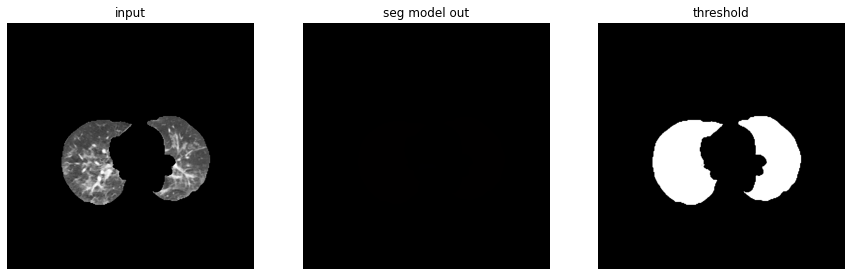

In [11]:
plt.figure(figsize=(15,5))



plt.subplot(1,3,1)
plt.title('input')
plt.imshow((img_ori*out_lung_np).astype('uint8'))
plt.axis('off')

# out_lung = img
plt.subplot(1,3,2)
plt.title('seg model out')
plt.imshow(out_lung.squeeze(dim=0).permute(1,2,0).numpy().astype('uint8'))
plt.axis('off')



plt.subplot(1,3,3)
plt.title('threshold')
plt.imshow(out_lung_np*img_ori, cmap='gray')
plt.axis('off')

(-0.5, 511.5, 511.5, -0.5)

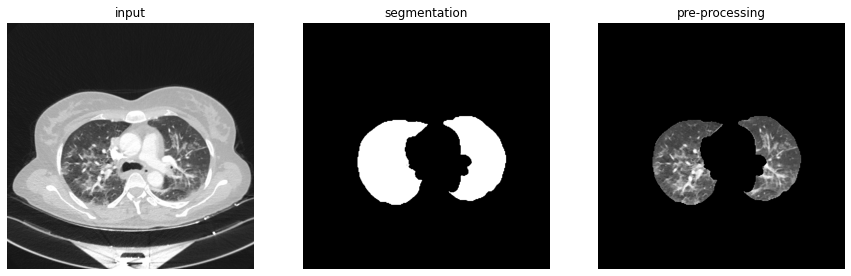

In [12]:
plt.figure(figsize=(15,5))



plt.subplot(1,3,1)
plt.title('input')
plt.imshow((img_ori).astype('uint8'))
plt.axis('off')


plt.subplot(1,3,2)
plt.title('segmentation')
plt.imshow(out_lung_np, cmap='gray')
plt.axis('off')

plt.subplot(1,3,3)
plt.title('pre-processing')
plt.imshow((out_lung_np*img_ori).astype('uint8'), cmap='gray')
plt.axis('off')

(-0.5, 511.5, 511.5, -0.5)

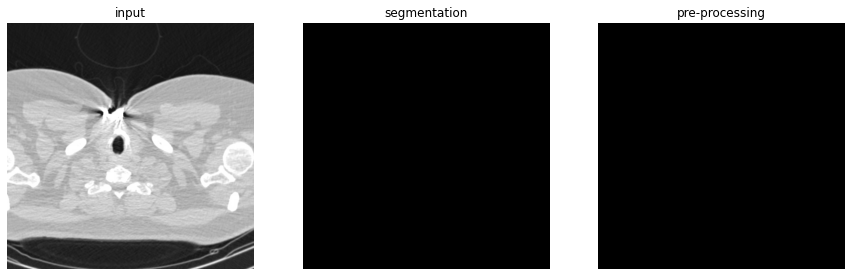

In [9]:
plt.figure(figsize=(15,5))



plt.subplot(1,3,1)
plt.title('input')
plt.imshow((img_ori).astype('uint8'))
plt.axis('off')


plt.subplot(1,3,2)
plt.title('segmentation')
plt.imshow(out_lung_np, cmap='gray')
plt.axis('off')

plt.subplot(1,3,3)
plt.title('pre-processing')
plt.imshow((out_lung_np*img_ori).astype('uint8'), cmap='gray')
plt.axis('off')